<a href="https://colab.research.google.com/github/tabba98/neural-network/blob/main/VoxNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the Libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics.classification import Accuracy
from torchmetrics import ConfusionMatrix

!pip install open3d;
import open3d as o3d

#for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

import scipy
from scipy.ndimage import rotate

import time
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 13.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.5/422.5 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 87.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 90.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.3/75.3 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.5 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
  Attempting uninstall: nbformat
    Found existing installation: nbformat 5.7.1
    Uninstalling nbformat-5.7.1:
      Successfully uninstalled nbformat-5.7.1


# Download and unzip the dataset ModelNet10

In [4]:
!wget http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip

--2023-02-01 15:31:02--  http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Resolving 3dvision.princeton.edu (3dvision.princeton.edu)... 128.112.136.74
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip [following]
--2023-02-01 15:31:02--  https://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip
Connecting to 3dvision.princeton.edu (3dvision.princeton.edu)|128.112.136.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 473402300 (451M) [application/zip]
Saving to: ‘ModelNet10.zip’

ModelNet10.zip      100%[===================>] 451.47M  24.3MB/s    in 20s     

2023-02-01 15:31:22 (22.8 MB/s) - ‘ModelNet10.zip’ saved [473402300/473402300]



In [5]:
!unzip -q ModelNet10.zip;

# Voxelization of the off. files in dataset

In [6]:
import os

ROOT = '/content/ModelNet10/'
CLASSES = ['bathtub', 'bed', 'chair', 'desk', 'dresser', 'monitor', 'night_stand', 'sofa', 'table', 'toilet']

X = {'train': [], 'test': []}
Y = {'train': [], 'test': []}

for label, cl in enumerate(CLASSES):
    for split in ['train', 'test']:
        examples_dir = os.path.join(ROOT, cl, split)
        for example in tqdm(os.listdir(examples_dir)):
          voxel_index = []
          if 'off' in example:
            mesh = o3d.io.read_triangle_mesh(examples_dir+'/'+example)
            mesh.scale(1 / np.max(mesh.get_max_bound() - mesh.get_min_bound()), center=mesh.get_center())
            voxel_grid = o3d.geometry.VoxelGrid.create_from_triangle_mesh(mesh, voxel_size=0.05)
            
            X[split].append(voxel_grid)
            Y[split].append(label)


100%|██████████| 101/101 [02:29<00:00,  1.48s/it]


# Dataset setup and Trainer

In [7]:
class VoxelDataset(Dataset):
    def __init__(self, train = True):
      if train:
          self.data = X['train']
          self.label = Y['train']
      else:
          self.data = X['test']
          self.label = Y['test']
        
                
    def __len__(self):
        return len(self.label)

    def __preproc__(self, voxels):
        
        voxel_grid = voxels.get_voxels()
        vox_g = np.zeros((32, 32, 32), dtype=np.int32)
        for i in range (len(voxel_grid)):
          voxel_index = voxel_grid[i].grid_index
          vox_g[voxel_index[0],voxel_index[1],voxel_index[2]] = 1

        #flip x
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=0)
        
        #flip y
        if np.random.randint(2):
            vox_g = np.flip(vox_g, axis=1)
        
        angle = 360 * np.random.random_sample(1)[0]
        vox_g = rotate(vox_g, axes=(0, 1), angle=angle, cval=0.0, reshape=False)  
        
        return vox_g.copy()

    def __getitem__(self, idx):
        label = self.label[idx]
        voxels = self.data[idx]
        voxels = self.__preproc__(voxels)
        voxels = np.expand_dims(voxels, axis=0)
        voxels = torch.tensor(voxels).float()
        return voxels, label

In [8]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class VoxNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.sgd_momentum = hyperparameters["sgd_momentum"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.lr_scheduler_step = hyperparameters["lr_scheduler_step"]
      self.lr_scheduler_gamma = hyperparameters["lr_scheduler_gamma"]
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = VoxelDataset(train=True)
      self.test_ds = VoxelDataset(train=False)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      if hyperparameters["model"] == "VoxNet":
          self.model = VoxNet()
          print("model VoxNet was chosen")
      elif hyperparameters["model"] == "BatchNormVoxNet":
          self.model = BatchNormVoxNet()
          print("model BatchNormVoxNet was chosen")
      else:
        self.model = DMPVoxNet()
        print('model DMPVoxNet was choosen')
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      #self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
      self.opt = SGD(self.model.parameters(), lr=self.learning_rate, momentum=self.sgd_momentum)
      #self.loss_fn = nn.CrossEntropyLoss()
      self.loss_fn = nn.NLLLoss()
      self.lr_scheduler = torch.optim.lr_scheduler.StepLR(self.opt, step_size=self.lr_scheduler_step, gamma=self.lr_scheduler_gamma)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          self.lr_scheduler.step()
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data[0], data[1]
              inputs = inputs.to(self.device)
              labels = labels.to(self.device)

              self.opt.zero_grad()
              pred = self.model(inputs)  # torch.Size([256, 10])
              loss = self.loss_fn(pred,labels)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(pred, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
              
              pred_choice = pred.data.max(1)[1]
              correct = pred_choice.eq(labels.data).cpu().sum()
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample[0], sample[1]
                inputs_test = inputs_test.to(self.device)
                labels_test = labels_test.to(self.device)
                inputs_test = inputs_test.float()  # 转float, torch.Size([256, 1, 32, 32, 32])
                
                pred_test = self.model(inputs_test)
                loss_test = self.loss_fn(pred_test, labels_test)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(pred_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = pred_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(pred_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()

  def draw_voxels(self):
      mesh = next(iter(self.train_dataloader))
      mesh = mesh[0][0][0]
        
      ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
      ax.voxels(mesh, edgecolor='k')
      plt.show()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

# VoxNet

In [9]:
from collections import OrderedDict
class VoxNet(nn.Module):
    def __init__(self):
        super(VoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**VoxNet** training

In [10]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'VoxNet'
}    

trainer1 = VoxNet_Trainer(training_hyperparameters)
trainer1.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


model VoxNet was chosen
124.71875


Train loss: 1.4108409881591797: : 124it [01:16,  1.62it/s]
29it [00:10,  2.89it/s]


epoch:  1 /100
time: 86.50 seconds
train-loss: 1.70, train-acc: 42.16%
valid-loss: 1.53, valid-acc: 43.06%



Train loss: 1.042795181274414: : 124it [01:17,  1.61it/s]
29it [00:10,  2.89it/s]


epoch:  2 /100
time: 87.20 seconds
train-loss: 1.23, train-acc: 57.46%
valid-loss: 1.26, valid-acc: 54.19%



Train loss: 1.1023178100585938: : 124it [01:14,  1.66it/s]
29it [00:09,  2.96it/s]


epoch:  3 /100
time: 84.37 seconds
train-loss: 1.05, train-acc: 63.51%
valid-loss: 1.44, valid-acc: 45.04%



Train loss: 0.8766392469406128: : 124it [01:14,  1.67it/s]
29it [00:10,  2.90it/s]


epoch:  4 /100
time: 84.20 seconds
train-loss: 0.90, train-acc: 68.65%
valid-loss: 0.94, valid-acc: 65.31%



Train loss: 1.154187560081482: : 124it [01:14,  1.66it/s]
29it [00:10,  2.84it/s]


epoch:  5 /100
time: 84.90 seconds
train-loss: 0.82, train-acc: 71.88%
valid-loss: 0.90, valid-acc: 67.73%



Train loss: 0.5317273736000061: : 124it [01:16,  1.62it/s]
29it [00:10,  2.86it/s]


epoch:  6 /100
time: 86.88 seconds
train-loss: 0.74, train-acc: 74.55%
valid-loss: 0.82, valid-acc: 70.15%



Train loss: 0.9947006702423096: : 124it [01:15,  1.65it/s]
29it [00:09,  2.91it/s]


epoch:  7 /100
time: 85.35 seconds
train-loss: 0.70, train-acc: 76.34%
valid-loss: 0.74, valid-acc: 73.35%



Train loss: 0.5178030729293823: : 124it [01:14,  1.67it/s]
29it [00:09,  2.93it/s]


epoch:  8 /100
time: 83.98 seconds
train-loss: 0.66, train-acc: 77.82%
valid-loss: 0.83, valid-acc: 69.49%



Train loss: 0.5431400537490845: : 124it [01:15,  1.64it/s]
29it [00:10,  2.89it/s]


epoch:  9 /100
time: 85.90 seconds
train-loss: 0.63, train-acc: 79.64%
valid-loss: 0.72, valid-acc: 76.32%



Train loss: 0.40743374824523926: : 124it [01:13,  1.68it/s]
29it [00:10,  2.85it/s]


epoch: 10 /100
time: 83.93 seconds
train-loss: 0.59, train-acc: 81.00%
valid-loss: 0.69, valid-acc: 75.66%



Train loss: 0.6649854183197021: : 124it [01:13,  1.68it/s]
29it [00:10,  2.89it/s]


epoch: 11 /100
time: 83.74 seconds
train-loss: 0.58, train-acc: 80.87%
valid-loss: 0.75, valid-acc: 73.68%



Train loss: 1.0054128170013428: : 124it [01:16,  1.63it/s]
29it [00:09,  2.91it/s]


epoch: 12 /100
time: 86.15 seconds
train-loss: 0.55, train-acc: 81.85%
valid-loss: 0.77, valid-acc: 72.36%



Train loss: 0.5355477333068848: : 124it [01:15,  1.64it/s]
29it [00:09,  2.92it/s]


epoch: 13 /100
time: 85.38 seconds
train-loss: 0.55, train-acc: 82.59%
valid-loss: 0.68, valid-acc: 75.88%



Train loss: 0.37873929738998413: : 124it [01:14,  1.66it/s]
29it [00:09,  2.94it/s]


epoch: 14 /100
time: 84.44 seconds
train-loss: 0.51, train-acc: 83.22%
valid-loss: 0.61, valid-acc: 78.30%



Train loss: 0.6359818577766418: : 124it [01:13,  1.68it/s]
29it [00:11,  2.58it/s]


epoch: 15 /100
time: 84.92 seconds
train-loss: 0.50, train-acc: 82.81%
valid-loss: 0.64, valid-acc: 78.19%



Train loss: 0.45384079217910767: : 124it [01:12,  1.70it/s]
29it [00:09,  2.99it/s]


epoch: 16 /100
time: 82.65 seconds
train-loss: 0.46, train-acc: 84.75%
valid-loss: 0.58, valid-acc: 80.73%



Train loss: 0.39395076036453247: : 124it [01:13,  1.68it/s]
29it [00:09,  2.92it/s]


epoch: 17 /100
time: 83.58 seconds
train-loss: 0.45, train-acc: 85.23%
valid-loss: 0.55, valid-acc: 80.51%



Train loss: 0.5681390166282654: : 124it [01:14,  1.67it/s]
29it [00:09,  2.95it/s]


epoch: 18 /100
time: 83.94 seconds
train-loss: 0.43, train-acc: 85.86%
valid-loss: 0.54, valid-acc: 82.16%



Train loss: 0.32992178201675415: : 124it [01:15,  1.65it/s]
29it [00:10,  2.80it/s]


epoch: 19 /100
time: 85.40 seconds
train-loss: 0.42, train-acc: 86.06%
valid-loss: 0.52, valid-acc: 81.72%



Train loss: 0.1970754861831665: : 124it [01:14,  1.67it/s]
29it [00:10,  2.84it/s]


epoch: 20 /100
time: 84.52 seconds
train-loss: 0.39, train-acc: 86.47%
valid-loss: 0.51, valid-acc: 81.94%



Train loss: 0.3204118311405182: : 124it [01:13,  1.69it/s]
29it [00:09,  2.97it/s]


epoch: 21 /100
time: 82.99 seconds
train-loss: 0.40, train-acc: 87.02%
valid-loss: 0.58, valid-acc: 81.72%



Train loss: 0.5247050523757935: : 124it [01:16,  1.63it/s]
29it [00:09,  2.97it/s]


epoch: 22 /100
time: 86.11 seconds
train-loss: 0.39, train-acc: 87.07%
valid-loss: 0.55, valid-acc: 81.17%



Train loss: 0.3052144944667816: : 124it [01:14,  1.67it/s]
29it [00:10,  2.87it/s]


epoch: 23 /100
time: 84.27 seconds
train-loss: 0.39, train-acc: 87.37%
valid-loss: 0.47, valid-acc: 83.70%



Train loss: 0.3076460659503937: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 24 /100
time: 84.54 seconds
train-loss: 0.37, train-acc: 87.83%
valid-loss: 0.50, valid-acc: 83.26%



Train loss: 0.27770254015922546: : 124it [01:15,  1.64it/s]
29it [00:10,  2.86it/s]


epoch: 25 /100
time: 85.57 seconds
train-loss: 0.36, train-acc: 87.47%
valid-loss: 0.52, valid-acc: 81.72%



Train loss: 0.3392862379550934: : 124it [01:14,  1.66it/s]
29it [00:09,  2.93it/s]


epoch: 26 /100
time: 84.44 seconds
train-loss: 0.36, train-acc: 88.05%
valid-loss: 0.51, valid-acc: 81.28%



Train loss: 0.2236478328704834: : 124it [01:13,  1.68it/s]
29it [00:10,  2.89it/s]


epoch: 27 /100
time: 83.89 seconds
train-loss: 0.36, train-acc: 87.37%
valid-loss: 0.48, valid-acc: 83.48%



Train loss: 0.38037917017936707: : 124it [01:14,  1.67it/s]
29it [00:11,  2.59it/s]


epoch: 28 /100
time: 85.42 seconds
train-loss: 0.34, train-acc: 88.68%
valid-loss: 0.47, valid-acc: 83.70%



Train loss: 0.20224228501319885: : 124it [01:14,  1.66it/s]
29it [00:09,  2.97it/s]


epoch: 29 /100
time: 84.34 seconds
train-loss: 0.33, train-acc: 88.76%
valid-loss: 0.47, valid-acc: 83.92%



0it [00:00, ?it/s]


KeyboardInterrupt: ignored

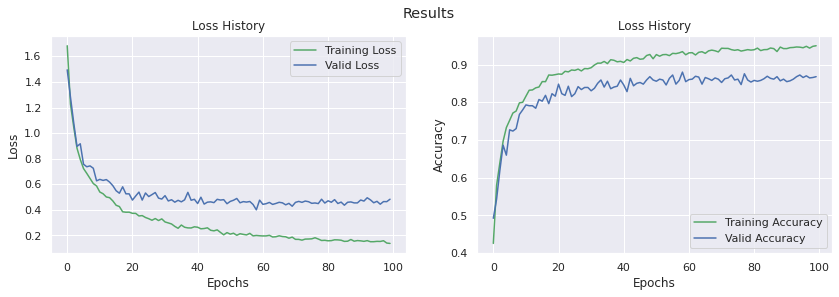

In [9]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history1 = trainer1.getHistory()
trainer1.showResults()

In [2]:
trainer1.generateConfusionMatrix()

NameError: ignored

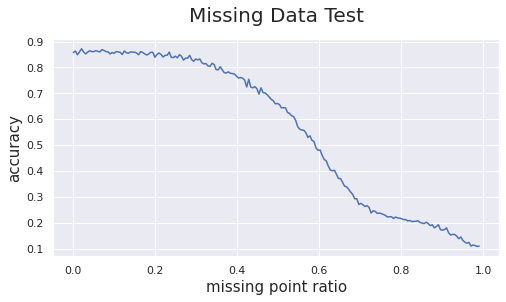

In [11]:
trainer1.missing_data_test()

# BatcNormVoxNet

In [12]:
from collections import OrderedDict
class BatchNormVoxNet(nn.Module):
    def __init__(self):
        super(BatchNormVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('batch1', torch.nn.BatchNorm3d(32)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('batch2', torch.nn.BatchNorm3d(32)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**BatchNormVoxNet** Training 

In [1]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'BatchNormVoxNet'
}    

trainer2 = VoxNet_Trainer(training_hyperparameters)
trainer2.train()

NameError: ignored

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history2 = trainer2.getHistory()
trainer2.showResults()

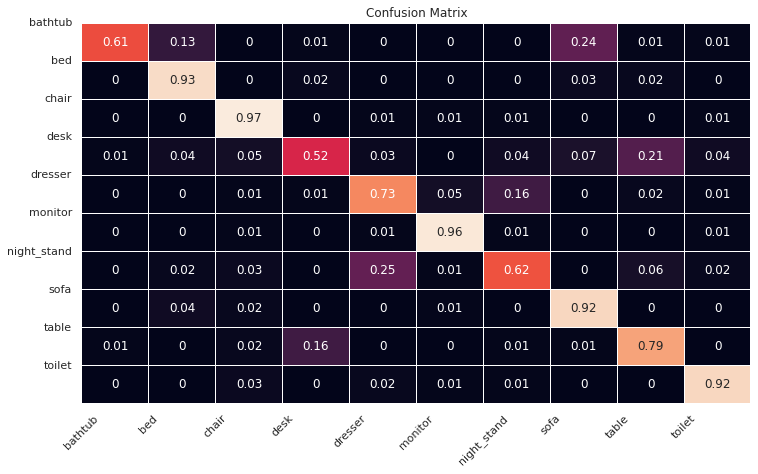

In [ ]:
trainer2.generateConfusionMatrix()

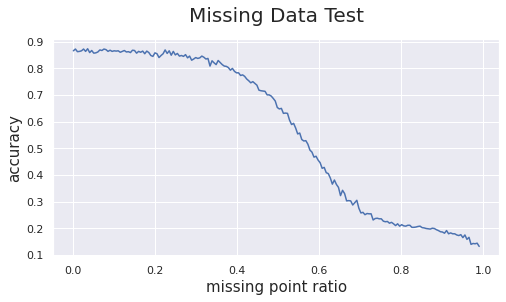

In [ ]:
trainer2.missing_data_test()

# DMPVoxNet (double-max-pooling VoxNet)

In [ ]:
from collections import OrderedDict
class DMPVoxNet(nn.Module):
    def __init__(self):
        super(DMPVoxNet, self).__init__()
        n_classes = 10
        input_shape = (32,32,32)
        self.feat = torch.nn.Sequential(OrderedDict([
            ('conv3d_1', torch.nn.Conv3d(in_channels=1, out_channels=32, kernel_size=5, stride=2)),
            ('relu1', torch.nn.ReLU()),
            ('drop1', torch.nn.Dropout(p=0.2)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3)),
            ('conv3d_2', torch.nn.Conv3d(in_channels=32, out_channels=128, kernel_size=3)),
            ('relu2', torch.nn.ReLU()),
            ('pool2', torch.nn.MaxPool3d(2)),
            ('drop2', torch.nn.Dropout(p=0.3))
        ]))
        
        x = self.feat(torch.autograd.Variable(torch.rand((1, 1) + input_shape)))
        dim_feat = 1
        for n in x.size()[1:]:
            dim_feat *= n

        self.mlp = torch.nn.Sequential(OrderedDict([
            ('fc1', torch.nn.Linear(dim_feat, 128)),
            ('relu1', torch.nn.ReLU()),
            ('drop3', torch.nn.Dropout(p=0.4)),
            ('fc2', torch.nn.Linear(128, n_classes))
        ]))

        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.feat(x)
        x = x.view(x.size(0), -1)
        x = self.mlp(x)
        #return x
        return self.logsoftmax(x)

**DMPVoxNet** training

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.1,
    "sgd_momentum": 0,
    "data_size": 32,
    "epochs": 100,
    "lr_scheduler_step": 16,
    "lr_scheduler_gamma": 0.7,
    "train_batch_size": 32,
    "valid_batch_size": 32,
    "model" : 'LightNet'
}    

trainer3 = VoxNet_Trainer(training_hyperparameters)
trainer3.train()

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


model LightNet was choosen
124.71875


Train loss: 0.9189271926879883: : 124it [01:49,  1.13it/s]
29it [00:10,  2.83it/s]


epoch:  1 /100
time: 119.61 seconds
train-loss: 1.61, train-acc: 44.93%
valid-loss: 1.53, valid-acc: 43.50%



Train loss: 1.1616851091384888: : 124it [01:49,  1.14it/s]
29it [00:13,  2.22it/s]


epoch:  2 /100
time: 122.18 seconds
train-loss: 1.18, train-acc: 58.92%
valid-loss: 1.27, valid-acc: 56.39%



Train loss: 0.9366999268531799: : 124it [01:47,  1.15it/s]
29it [00:10,  2.84it/s]


epoch:  3 /100
time: 118.07 seconds
train-loss: 0.98, train-acc: 65.85%
valid-loss: 0.98, valid-acc: 64.76%



Train loss: 0.6858680248260498: : 124it [01:48,  1.15it/s]
29it [00:10,  2.65it/s]


epoch:  4 /100
time: 119.01 seconds
train-loss: 0.84, train-acc: 70.89%
valid-loss: 0.89, valid-acc: 68.06%



Train loss: 0.8790099024772644: : 124it [01:47,  1.15it/s]
29it [00:10,  2.90it/s]


epoch:  5 /100
time: 117.68 seconds
train-loss: 0.76, train-acc: 74.07%
valid-loss: 0.80, valid-acc: 71.37%



Train loss: 0.42607033252716064: : 124it [01:47,  1.15it/s]
29it [00:10,  2.87it/s]


epoch:  6 /100
time: 117.74 seconds
train-loss: 0.69, train-acc: 75.93%
valid-loss: 0.73, valid-acc: 74.12%



Train loss: 0.6742552518844604: : 124it [01:48,  1.14it/s]
29it [00:10,  2.80it/s]


epoch:  7 /100
time: 118.87 seconds
train-loss: 0.64, train-acc: 78.53%
valid-loss: 0.66, valid-acc: 74.78%



Train loss: 0.9203929305076599: : 124it [01:48,  1.15it/s]
29it [00:10,  2.83it/s]


epoch:  8 /100
time: 118.27 seconds
train-loss: 0.61, train-acc: 79.71%
valid-loss: 0.71, valid-acc: 75.11%



Train loss: 0.591471791267395: : 124it [01:48,  1.14it/s]
29it [00:10,  2.85it/s]


epoch:  9 /100
time: 118.82 seconds
train-loss: 0.58, train-acc: 80.49%
valid-loss: 0.63, valid-acc: 78.41%



Train loss: 0.3905385136604309: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 10 /100
time: 117.95 seconds
train-loss: 0.55, train-acc: 81.75%
valid-loss: 0.64, valid-acc: 76.32%



Train loss: 0.4879913330078125: : 124it [01:48,  1.14it/s]
29it [00:10,  2.85it/s]


epoch: 11 /100
time: 118.54 seconds
train-loss: 0.49, train-acc: 83.62%
valid-loss: 0.65, valid-acc: 78.74%



Train loss: 0.6662464141845703: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 12 /100
time: 118.18 seconds
train-loss: 0.49, train-acc: 83.80%
valid-loss: 0.61, valid-acc: 78.19%



Train loss: 0.5287050604820251: : 124it [01:48,  1.14it/s]
29it [00:10,  2.87it/s]


epoch: 13 /100
time: 118.72 seconds
train-loss: 0.46, train-acc: 84.63%
valid-loss: 0.62, valid-acc: 78.52%



Train loss: 0.2702490985393524: : 124it [01:47,  1.15it/s]
29it [00:10,  2.88it/s]


epoch: 14 /100
time: 118.05 seconds
train-loss: 0.44, train-acc: 85.06%
valid-loss: 0.62, valid-acc: 80.95%



Train loss: 0.5565543174743652: : 124it [01:48,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 15 /100
time: 118.40 seconds
train-loss: 0.43, train-acc: 85.38%
valid-loss: 0.56, valid-acc: 81.17%



Train loss: 0.5367357134819031: : 124it [01:48,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 16 /100
time: 118.37 seconds
train-loss: 0.39, train-acc: 86.82%
valid-loss: 0.57, valid-acc: 80.62%



Train loss: 0.5261130332946777: : 124it [01:48,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 17 /100
time: 118.39 seconds
train-loss: 0.38, train-acc: 87.60%
valid-loss: 0.56, valid-acc: 81.06%



Train loss: 0.23815758526325226: : 124it [01:47,  1.15it/s]
29it [00:10,  2.78it/s]


epoch: 18 /100
time: 118.31 seconds
train-loss: 0.37, train-acc: 87.42%
valid-loss: 0.52, valid-acc: 82.60%



Train loss: 0.26141974329948425: : 124it [01:47,  1.15it/s]
29it [00:10,  2.65it/s]


epoch: 19 /100
time: 118.73 seconds
train-loss: 0.34, train-acc: 88.38%
valid-loss: 0.51, valid-acc: 83.37%



Train loss: 0.36358731985092163: : 124it [01:47,  1.15it/s]
29it [00:10,  2.80it/s]


epoch: 20 /100
time: 118.11 seconds
train-loss: 0.34, train-acc: 87.95%
valid-loss: 0.50, valid-acc: 82.38%



Train loss: 0.16438335180282593: : 124it [01:47,  1.15it/s]
29it [00:10,  2.88it/s]


epoch: 21 /100
time: 118.02 seconds
train-loss: 0.34, train-acc: 88.48%
valid-loss: 0.50, valid-acc: 82.05%



Train loss: 0.24090565741062164: : 124it [01:48,  1.14it/s]
29it [00:10,  2.83it/s]


epoch: 22 /100
time: 119.00 seconds
train-loss: 0.32, train-acc: 89.24%
valid-loss: 0.51, valid-acc: 81.94%



Train loss: 0.12154103815555573: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 23 /100
time: 118.23 seconds
train-loss: 0.31, train-acc: 89.42%
valid-loss: 0.53, valid-acc: 83.15%



Train loss: 0.12212663888931274: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 24 /100
time: 118.75 seconds
train-loss: 0.30, train-acc: 89.82%
valid-loss: 0.53, valid-acc: 82.82%



Train loss: 0.3007546365261078: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 25 /100
time: 118.34 seconds
train-loss: 0.31, train-acc: 89.36%
valid-loss: 0.48, valid-acc: 84.58%



Train loss: 0.2236444503068924: : 124it [01:48,  1.14it/s]
29it [00:10,  2.88it/s]


epoch: 26 /100
time: 118.87 seconds
train-loss: 0.29, train-acc: 89.72%
valid-loss: 0.45, valid-acc: 84.47%



Train loss: 0.3895202875137329: : 124it [01:48,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 27 /100
time: 118.31 seconds
train-loss: 0.28, train-acc: 90.32%
valid-loss: 0.51, valid-acc: 83.15%



Train loss: 0.23359881341457367: : 124it [01:48,  1.14it/s]
29it [00:10,  2.87it/s]


epoch: 28 /100
time: 118.49 seconds
train-loss: 0.28, train-acc: 90.65%
valid-loss: 0.48, valid-acc: 84.47%



Train loss: 0.11019819974899292: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 29 /100
time: 118.30 seconds
train-loss: 0.28, train-acc: 90.20%
valid-loss: 0.47, valid-acc: 84.25%



Train loss: 0.30732226371765137: : 124it [01:48,  1.14it/s]
29it [00:10,  2.87it/s]


epoch: 30 /100
time: 118.90 seconds
train-loss: 0.28, train-acc: 89.79%
valid-loss: 0.45, valid-acc: 83.92%



Train loss: 0.23165538907051086: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 31 /100
time: 117.99 seconds
train-loss: 0.26, train-acc: 90.98%
valid-loss: 0.47, valid-acc: 84.47%



Train loss: 0.10519981384277344: : 124it [01:48,  1.14it/s]
29it [00:10,  2.82it/s]


epoch: 32 /100
time: 118.83 seconds
train-loss: 0.24, train-acc: 91.78%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.2560104727745056: : 124it [01:47,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 33 /100
time: 118.00 seconds
train-loss: 0.24, train-acc: 91.76%
valid-loss: 0.44, valid-acc: 84.36%



Train loss: 0.18633021414279938: : 124it [01:48,  1.14it/s]
29it [00:10,  2.87it/s]


epoch: 34 /100
time: 118.46 seconds
train-loss: 0.22, train-acc: 92.04%
valid-loss: 0.47, valid-acc: 84.47%



Train loss: 0.16911014914512634: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 35 /100
time: 117.73 seconds
train-loss: 0.22, train-acc: 92.36%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.11647308617830276: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 36 /100
time: 118.26 seconds
train-loss: 0.23, train-acc: 91.71%
valid-loss: 0.46, valid-acc: 84.47%



Train loss: 0.09785620123147964: : 124it [01:47,  1.15it/s]
29it [00:10,  2.88it/s]


epoch: 37 /100
time: 117.90 seconds
train-loss: 0.22, train-acc: 92.57%
valid-loss: 0.47, valid-acc: 84.91%



Train loss: 0.18194642663002014: : 124it [01:48,  1.14it/s]
29it [00:10,  2.82it/s]


epoch: 38 /100
time: 118.91 seconds
train-loss: 0.22, train-acc: 92.46%
valid-loss: 0.46, valid-acc: 85.02%



Train loss: 0.2624586522579193: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 39 /100
time: 118.51 seconds
train-loss: 0.21, train-acc: 92.64%
valid-loss: 0.46, valid-acc: 85.35%



Train loss: 0.2830209732055664: : 124it [01:47,  1.15it/s]
29it [00:10,  2.64it/s]


epoch: 40 /100
time: 118.80 seconds
train-loss: 0.21, train-acc: 93.02%
valid-loss: 0.43, valid-acc: 86.12%



Train loss: 0.22995397448539734: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 41 /100
time: 118.03 seconds
train-loss: 0.21, train-acc: 92.82%
valid-loss: 0.48, valid-acc: 84.80%



Train loss: 0.30250146985054016: : 124it [01:47,  1.15it/s]
29it [00:11,  2.62it/s]


epoch: 42 /100
time: 118.87 seconds
train-loss: 0.20, train-acc: 92.72%
valid-loss: 0.45, valid-acc: 85.24%



Train loss: 0.24953490495681763: : 124it [01:48,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 43 /100
time: 118.29 seconds
train-loss: 0.20, train-acc: 92.99%
valid-loss: 0.47, valid-acc: 84.36%



Train loss: 0.09719614684581757: : 124it [01:47,  1.15it/s]
29it [00:11,  2.61it/s]


epoch: 44 /100
time: 118.49 seconds
train-loss: 0.20, train-acc: 93.22%
valid-loss: 0.47, valid-acc: 85.02%



Train loss: 0.1543123871088028: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 45 /100
time: 118.56 seconds
train-loss: 0.18, train-acc: 93.57%
valid-loss: 0.48, valid-acc: 84.25%



Train loss: 0.12202399969100952: : 124it [01:47,  1.16it/s]
29it [00:10,  2.64it/s]


epoch: 46 /100
time: 118.31 seconds
train-loss: 0.20, train-acc: 93.02%
valid-loss: 0.46, valid-acc: 85.46%



Train loss: 0.18758082389831543: : 124it [01:47,  1.15it/s]
29it [00:10,  2.88it/s]


epoch: 47 /100
time: 117.86 seconds
train-loss: 0.19, train-acc: 93.42%
valid-loss: 0.44, valid-acc: 86.45%



Train loss: 0.19615398347377777: : 124it [01:47,  1.15it/s]
29it [00:10,  2.66it/s]


epoch: 48 /100
time: 118.57 seconds
train-loss: 0.19, train-acc: 93.27%
valid-loss: 0.44, valid-acc: 85.46%



Train loss: 0.2162618637084961: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 49 /100
time: 117.65 seconds
train-loss: 0.18, train-acc: 93.67%
valid-loss: 0.44, valid-acc: 86.01%



Train loss: 0.22160066664218903: : 124it [01:47,  1.16it/s]
29it [00:10,  2.64it/s]


epoch: 50 /100
time: 118.28 seconds
train-loss: 0.17, train-acc: 93.72%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.1573757827281952: : 124it [01:47,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 51 /100
time: 118.01 seconds
train-loss: 0.17, train-acc: 93.95%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.17386411130428314: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 52 /100
time: 118.42 seconds
train-loss: 0.17, train-acc: 93.90%
valid-loss: 0.52, valid-acc: 85.46%



Train loss: 0.5918559432029724: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 53 /100
time: 117.59 seconds
train-loss: 0.18, train-acc: 93.62%
valid-loss: 0.44, valid-acc: 86.12%



Train loss: 0.4710507094860077: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 54 /100
time: 118.33 seconds
train-loss: 0.16, train-acc: 94.56%
valid-loss: 0.47, valid-acc: 86.56%



Train loss: 0.2125610113143921: : 124it [01:47,  1.16it/s]
29it [00:10,  2.90it/s]


epoch: 55 /100
time: 117.14 seconds
train-loss: 0.16, train-acc: 94.25%
valid-loss: 0.45, valid-acc: 86.01%



Train loss: 0.11745148152112961: : 124it [01:48,  1.15it/s]
29it [00:10,  2.89it/s]


epoch: 56 /100
time: 118.25 seconds
train-loss: 0.17, train-acc: 93.90%
valid-loss: 0.45, valid-acc: 86.56%



Train loss: 0.1020231619477272: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 57 /100
time: 117.94 seconds
train-loss: 0.16, train-acc: 94.28%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.16157066822052002: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 58 /100
time: 118.47 seconds
train-loss: 0.14, train-acc: 94.86%
valid-loss: 0.44, valid-acc: 87.11%



Train loss: 0.166560098528862: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 59 /100
time: 117.56 seconds
train-loss: 0.16, train-acc: 94.78%
valid-loss: 0.45, valid-acc: 85.90%



Train loss: 0.25592881441116333: : 124it [01:47,  1.15it/s]
29it [00:11,  2.63it/s]


epoch: 60 /100
time: 118.69 seconds
train-loss: 0.16, train-acc: 94.15%
valid-loss: 0.46, valid-acc: 85.46%



Train loss: 0.21988463401794434: : 124it [01:47,  1.15it/s]
29it [00:10,  2.84it/s]


epoch: 61 /100
time: 117.81 seconds
train-loss: 0.16, train-acc: 94.53%
valid-loss: 0.46, valid-acc: 86.23%



Train loss: 0.1315658688545227: : 124it [01:50,  1.13it/s]
29it [00:10,  2.84it/s]


epoch: 62 /100
time: 120.40 seconds
train-loss: 0.15, train-acc: 94.78%
valid-loss: 0.39, valid-acc: 87.44%



Train loss: 0.3445724546909332: : 124it [01:47,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 63 /100
time: 117.50 seconds
train-loss: 0.14, train-acc: 94.76%
valid-loss: 0.46, valid-acc: 86.01%



Train loss: 0.17564471065998077: : 124it [01:48,  1.14it/s]
29it [00:10,  2.83it/s]


epoch: 64 /100
time: 118.73 seconds
train-loss: 0.14, train-acc: 94.96%
valid-loss: 0.45, valid-acc: 85.90%



Train loss: 0.03410932049155235: : 124it [01:47,  1.15it/s]
29it [00:10,  2.89it/s]


epoch: 65 /100
time: 117.78 seconds
train-loss: 0.13, train-acc: 95.31%
valid-loss: 0.44, valid-acc: 86.78%



Train loss: 0.20191654562950134: : 124it [01:48,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 66 /100
time: 118.40 seconds
train-loss: 0.14, train-acc: 94.61%
valid-loss: 0.43, valid-acc: 87.00%



Train loss: 0.08519304543733597: : 124it [01:47,  1.16it/s]
29it [00:10,  2.82it/s]


epoch: 67 /100
time: 117.65 seconds
train-loss: 0.13, train-acc: 95.29%
valid-loss: 0.47, valid-acc: 85.79%



Train loss: 0.2140868753194809: : 124it [01:48,  1.14it/s]
29it [00:10,  2.85it/s]


epoch: 68 /100
time: 118.54 seconds
train-loss: 0.13, train-acc: 95.09%
valid-loss: 0.48, valid-acc: 85.79%



Train loss: 0.04922643303871155: : 124it [01:47,  1.15it/s]
29it [00:10,  2.84it/s]


epoch: 69 /100
time: 117.81 seconds
train-loss: 0.14, train-acc: 95.14%
valid-loss: 0.45, valid-acc: 86.12%



Train loss: 0.12022003531455994: : 124it [01:48,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 70 /100
time: 118.23 seconds
train-loss: 0.13, train-acc: 95.24%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.0904478132724762: : 124it [01:47,  1.16it/s]
29it [00:10,  2.87it/s]


epoch: 71 /100
time: 117.43 seconds
train-loss: 0.13, train-acc: 94.86%
valid-loss: 0.48, valid-acc: 85.46%



Train loss: 0.06293418258428574: : 124it [01:48,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 72 /100
time: 118.25 seconds
train-loss: 0.13, train-acc: 94.93%
valid-loss: 0.45, valid-acc: 85.46%



Train loss: 0.1083182767033577: : 124it [01:47,  1.15it/s]
29it [00:10,  2.88it/s]


epoch: 73 /100
time: 117.70 seconds
train-loss: 0.14, train-acc: 95.04%
valid-loss: 0.44, valid-acc: 86.01%



Train loss: 0.15141485631465912: : 124it [01:48,  1.14it/s]
29it [00:10,  2.84it/s]


epoch: 74 /100
time: 118.76 seconds
train-loss: 0.12, train-acc: 95.72%
valid-loss: 0.48, valid-acc: 86.67%



Train loss: 0.09466306120157242: : 124it [01:48,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 75 /100
time: 118.35 seconds
train-loss: 0.13, train-acc: 95.39%
valid-loss: 0.45, valid-acc: 87.33%



Train loss: 0.19643528759479523: : 124it [01:48,  1.14it/s]
29it [00:10,  2.83it/s]


epoch: 76 /100
time: 119.13 seconds
train-loss: 0.14, train-acc: 95.26%
valid-loss: 0.45, valid-acc: 86.56%



Train loss: 0.28355512022972107: : 124it [01:47,  1.15it/s]
29it [00:10,  2.84it/s]


epoch: 77 /100
time: 118.12 seconds
train-loss: 0.12, train-acc: 95.51%
valid-loss: 0.46, valid-acc: 86.45%



Train loss: 0.040004536509513855: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 78 /100
time: 118.59 seconds
train-loss: 0.12, train-acc: 95.72%
valid-loss: 0.46, valid-acc: 86.89%



Train loss: 0.11826355010271072: : 124it [01:47,  1.15it/s]
29it [00:10,  2.89it/s]


epoch: 79 /100
time: 117.56 seconds
train-loss: 0.12, train-acc: 95.59%
valid-loss: 0.47, valid-acc: 86.34%



Train loss: 0.03833471238613129: : 124it [01:48,  1.14it/s]
29it [00:10,  2.87it/s]


epoch: 80 /100
time: 118.59 seconds
train-loss: 0.11, train-acc: 95.84%
valid-loss: 0.48, valid-acc: 87.44%



Train loss: 0.029071573168039322: : 124it [01:47,  1.15it/s]
29it [00:10,  2.65it/s]


epoch: 81 /100
time: 118.64 seconds
train-loss: 0.11, train-acc: 96.19%
valid-loss: 0.46, valid-acc: 87.22%



Train loss: 0.24996690452098846: : 124it [01:47,  1.15it/s]
29it [00:10,  2.84it/s]


epoch: 82 /100
time: 117.95 seconds
train-loss: 0.12, train-acc: 95.92%
valid-loss: 0.47, valid-acc: 86.67%



Train loss: 0.0625431016087532: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 83 /100
time: 118.40 seconds
train-loss: 0.12, train-acc: 96.19%
valid-loss: 0.47, valid-acc: 86.78%



Train loss: 0.06214116886258125: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 84 /100
time: 117.86 seconds
train-loss: 0.12, train-acc: 95.69%
valid-loss: 0.45, valid-acc: 86.56%



Train loss: 0.15061348676681519: : 124it [01:48,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 85 /100
time: 118.49 seconds
train-loss: 0.12, train-acc: 95.49%
valid-loss: 0.43, valid-acc: 87.56%



Train loss: 0.04981676861643791: : 124it [01:47,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 86 /100
time: 117.86 seconds
train-loss: 0.12, train-acc: 95.97%
valid-loss: 0.46, valid-acc: 86.56%



Train loss: 0.06912816315889359: : 124it [01:48,  1.14it/s]
29it [00:10,  2.84it/s]


epoch: 87 /100
time: 118.78 seconds
train-loss: 0.11, train-acc: 96.27%
valid-loss: 0.46, valid-acc: 86.34%



Train loss: 0.20887380838394165: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 88 /100
time: 117.96 seconds
train-loss: 0.10, train-acc: 96.42%
valid-loss: 0.47, valid-acc: 86.89%



Train loss: 0.04999283328652382: : 124it [01:48,  1.14it/s]
29it [00:10,  2.85it/s]


epoch: 89 /100
time: 118.66 seconds
train-loss: 0.11, train-acc: 95.87%
valid-loss: 0.51, valid-acc: 87.00%



Train loss: 0.08218562602996826: : 124it [01:47,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 90 /100
time: 118.04 seconds
train-loss: 0.11, train-acc: 96.19%
valid-loss: 0.44, valid-acc: 87.78%



Train loss: 0.17896729707717896: : 124it [01:48,  1.15it/s]
29it [00:10,  2.86it/s]


epoch: 91 /100
time: 118.42 seconds
train-loss: 0.11, train-acc: 96.37%
valid-loss: 0.48, valid-acc: 86.89%



Train loss: 0.2726161479949951: : 124it [01:47,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 92 /100
time: 117.75 seconds
train-loss: 0.11, train-acc: 95.79%
valid-loss: 0.49, valid-acc: 87.11%



Train loss: 0.07237274944782257: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 93 /100
time: 118.90 seconds
train-loss: 0.11, train-acc: 96.19%
valid-loss: 0.47, valid-acc: 86.23%



Train loss: 0.03473605215549469: : 124it [01:47,  1.15it/s]
29it [00:10,  2.64it/s]


epoch: 94 /100
time: 118.75 seconds
train-loss: 0.10, train-acc: 96.24%
valid-loss: 0.46, valid-acc: 86.89%



Train loss: 0.1252702921628952: : 124it [01:47,  1.15it/s]
29it [00:10,  2.83it/s]


epoch: 95 /100
time: 118.00 seconds
train-loss: 0.12, train-acc: 95.79%
valid-loss: 0.47, valid-acc: 87.56%



Train loss: 0.0973450094461441: : 124it [01:48,  1.14it/s]
29it [00:10,  2.84it/s]


epoch: 96 /100
time: 119.08 seconds
train-loss: 0.10, train-acc: 96.27%
valid-loss: 0.47, valid-acc: 87.89%



Train loss: 0.09917228668928146: : 124it [01:47,  1.15it/s]
29it [00:10,  2.85it/s]


epoch: 97 /100
time: 117.97 seconds
train-loss: 0.10, train-acc: 96.30%
valid-loss: 0.46, valid-acc: 86.56%



Train loss: 0.12111572921276093: : 124it [01:48,  1.14it/s]
29it [00:10,  2.86it/s]


epoch: 98 /100
time: 118.72 seconds
train-loss: 0.11, train-acc: 96.07%
valid-loss: 0.47, valid-acc: 86.67%



Train loss: 0.170148566365242: : 124it [01:47,  1.15it/s]
29it [00:10,  2.87it/s]


epoch: 99 /100
time: 117.75 seconds
train-loss: 0.09, train-acc: 96.67%
valid-loss: 0.50, valid-acc: 87.11%



Train loss: 0.12975545227527618: : 124it [01:48,  1.14it/s]
29it [00:10,  2.88it/s]

epoch:100 /100
time: 118.58 seconds
train-loss: 0.10, train-acc: 96.57%
valid-loss: 0.46, valid-acc: 87.22%



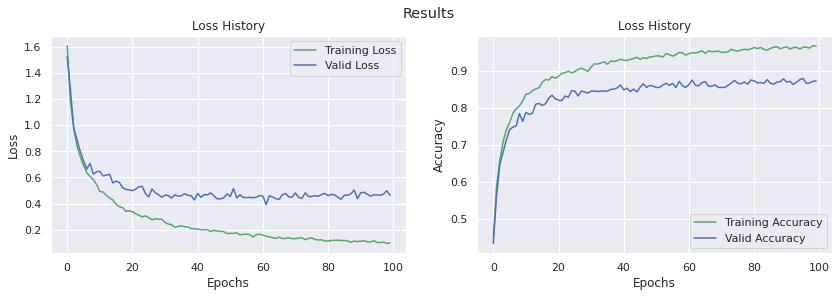

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

history3 = trainer3.getHistory()
trainer3.showResults()

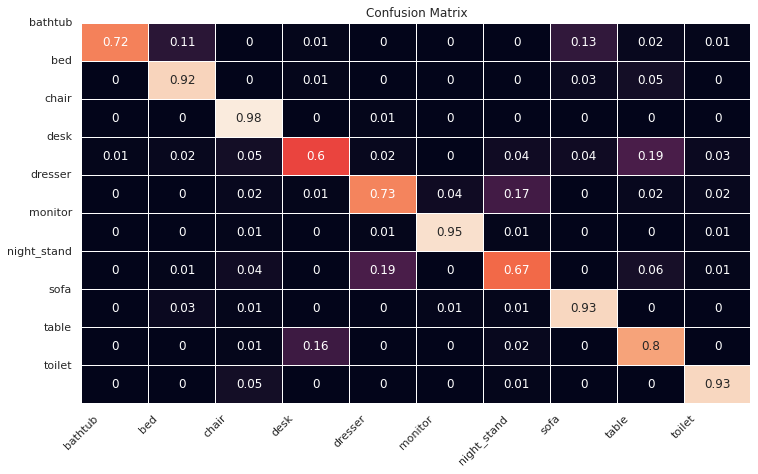

In [ ]:
trainer3.generateConfusionMatrix()

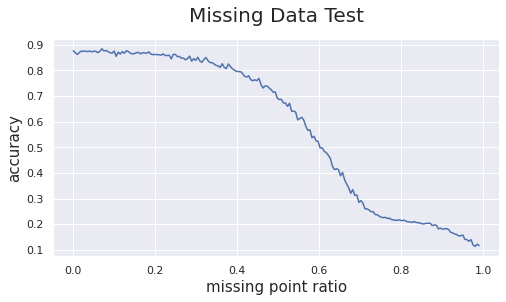

In [ ]:
trainer3.missing_data_test()

# VoxNet model comparison

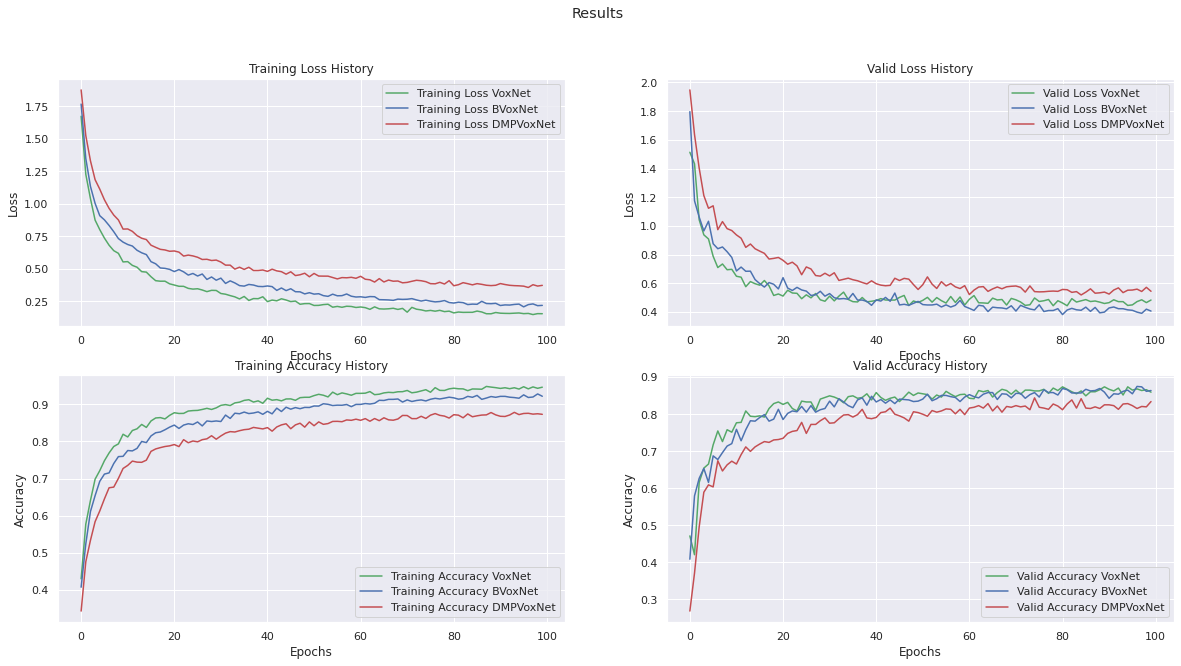

In [ ]:
def smooth(x, w=0):
    last = x[0]
    smoothed = []
    for point in x:
      smoothed_val = w * last + (1 - w) * point
      smoothed.append(smoothed_val)
      ast = smoothed_val
          
    return smoothed

eps = range(0, len(history1["train_loss"].cpu()))
        
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Results')
        
ax[0,0].plot(eps, smooth(history1["train_loss"].cpu()), 'g', label='Training Loss VoxNet')
ax[0,0].plot(eps, smooth(history2["train_loss"].cpu()), 'b', label='Training Loss BVoxNet')
ax[0,0].plot(eps, smooth(history3["train_loss"].cpu()), 'r', label='Training Loss DMPVoxNet')
ax[0,0].set_title('Training Loss History')
ax[0,0].set(xlabel='Epochs', ylabel='Loss')
ax[0,0].legend()
        
ax[0,1].plot(eps, smooth(history1["valid_loss"].cpu()), 'g', label='Valid Loss VoxNet')
ax[0,1].plot(eps, smooth(history2["valid_loss"].cpu()), 'b', label='Valid Loss BVoxNet')
ax[0,1].plot(eps, smooth(history3["valid_loss"].cpu()), 'r', label='Valid Loss DMPVoxNet')
ax[0,1].set_title('Valid Loss History')
ax[0,1].set(xlabel='Epochs', ylabel='Loss')
ax[0,1].legend()

ax[1,0].plot(eps, smooth(history1["train_acc"].cpu()), 'g', label='Training Accuracy VoxNet')
ax[1,0].plot(eps, smooth(history2["train_acc"].cpu()), 'b', label='Training Accuracy BVoxNet')
ax[1,0].plot(eps, smooth(history3["train_acc"].cpu()), 'r', label='Training Accuracy DMPVoxNet')
ax[1,0].set_title('Training Accuracy History')
ax[1,0].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,0].legend()

ax[1,1].plot(eps, smooth(history1["valid_acc"].cpu()), 'g', label='Valid Accuracy VoxNet')
ax[1,1].plot(eps, smooth(history2["valid_acc"].cpu()), 'b', label='Valid Accuracy BVoxNet')
ax[1,1].plot(eps, smooth(history3["valid_acc"].cpu()), 'r', label='Valid Accuracy DMPVoxNet')
ax[1,1].set_title('Valid Accuracy History')
ax[1,1].set(xlabel='Epochs', ylabel='Accuracy')
ax[1,1].legend()

# PointNet

In [ ]:
import os
import random
import math

!pip install path.py;
from path import Path

path = Path("ModelNet10")

folders = [dir for dir in sorted(os.listdir(path)) if os.path.isdir(path/dir)]
classes = {folder: i for i, folder in enumerate(folders)};

def read_off(file):
    if 'OFF' != file.readline().strip():
        raise('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * ( side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        # barycentric coordinates on a triangle
        # https://mathworld.wolfram.com/BarycentricCoordinates.html
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t-s)*pt2[i] + (1-t)*pt3[i]
        return (f(0), f(1), f(2))
        
    
    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = (self.triangle_area(verts[faces[i][0]], verts[faces[i][1]], verts[faces[i][2]]))
            
        sampled_faces = (random.choices(faces, weights=areas, cum_weights=None, k=self.output_size))
        
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = (self.sample_point(verts[sampled_faces[i][0]], verts[sampled_faces[i][1]], verts[sampled_faces[i][2]]))
        
        return sampled_points


class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        norm_pointcloud = pointcloud - np.mean(pointcloud, axis=0) 
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta),    0],
                               [ math.sin(theta),  math.cos(theta),    0],
                               [0,                             0,      1]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud
    
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.02, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

class ToTensor(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)

In [ ]:
def default_transforms():
    return transforms.Compose([PointSampler(1024),
                                Normalize(),
                                ToTensor()
                              ])

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
class PointCloudData(Dataset):
    def __init__(self, root_dir, valid=False, folder="train", transform=default_transforms()):
        self.root_dir = root_dir
        folders = [dir for dir in sorted(os.listdir(root_dir)) if os.path.isdir(root_dir/dir)]
        self.classes = {folder: i for i, folder in enumerate(folders)}
        self.transforms = transform if not valid else default_transforms()
        self.valid = valid
        self.files = []
        for category in self.classes.keys():
            new_dir = root_dir/Path(category)/folder
            for file in os.listdir(new_dir):
                if file.endswith('.off'):
                    sample = {}
                    sample['pcd_path'] = new_dir/file
                    sample['category'] = category
                    self.files.append(sample)

    def __len__(self):
        return len(self.files)

    def __preproc__(self, file):
        verts, faces = read_off(file)
        if self.transforms:
            pointcloud = self.transforms((verts, faces))
        return pointcloud

    def __getitem__(self, idx):
        pcd_path = self.files[idx]['pcd_path']
        category = self.files[idx]['category']
        with open(pcd_path, 'r') as f:
            pointcloud = self.__preproc__(f)
        return {'pointcloud': pointcloud, 'category': self.classes[category]}

In [ ]:
train_transforms = transforms.Compose([
                    PointSampler(1024),
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
   def forward(self, input):
        matrix3x3 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix3x3, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

class PointNet_Trainer():
  def __init__(self, hyperparameters):
      #Hypreparameters
      self.learning_rate = hyperparameters["learning_rate"]
      self.batch_size_train = hyperparameters["train_batch_size"]
      self.batch_size_test = hyperparameters["valid_batch_size"]
      self.data_size = hyperparameters["data_size"]
      self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
      self.epochs = hyperparameters["epochs"]
      
      #Dataset
      self.initDataset()
      self.class_names = ["bathtub", "bed", "chair", "desk", "dresser", "monitor", "night_stand", "sofa", "table", "toilet"]
      self.num_classes = len(self.class_names)

      #Model
      self.initModel(hyperparameters)
  
  def initDataset(self):
      self.train_ds = PointCloudData(path, transform=train_transforms)
      self.test_ds = PointCloudData(path, valid=True, folder='test', transform=train_transforms)
      self.train_dataloader = DataLoader(dataset=self.train_ds, batch_size=self.batch_size_train, shuffle=True, drop_last=True)
      self.test_dataloader = DataLoader(dataset=self.test_ds, batch_size=self.batch_size_test)

  def initModel(self, hyperparameters):
      self.model = PointNet()
      print("model PointNet was chosen")
      self.device = "cuda" if torch.cuda.is_available() else "cpu"
      self.model.to(self.device)
      self.opt = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

  def train(self):
      self.pred_conf, self.y_conf = [], []                                                           
      train_loss_history, valid_loss_history = [], []
      train_acc_history, valid_acc_history = [], []
      train_accuracy = Accuracy(task='multiclass', num_classes=10)
      valid_accuracy = Accuracy(task='multiclass', num_classes=10)

      self.num_batch = len(self.train_ds) / self.batch_size_train
      print(self.num_batch)

      total_time = time.time()

      for epoch in range(self.epochs):
          t = time.time()

          train_loss = []                                                         #track training loss
          valid_loss = []
          self.model.train()
          iterator = tqdm(enumerate(self.train_dataloader, 0))
          for i, data in iterator:
              inputs, labels = data['pointcloud'].to(self.device).float(), data['category'].to(self.device)

              self.opt.zero_grad()
              outputs, m3x3, m64x64 = self.model(inputs.transpose(1,2))  # torch.Size([256, 10])
              loss = pointnetloss(outputs, labels, m3x3, m64x64)
              train_loss.append(loss.cpu().data)
              train_accuracy.update(torch.argmax(outputs, 1).cpu(), labels.cpu()) 

              loss.backward()
              self.opt.step()
              iterator.set_description(f"Train loss: {loss.cpu().data}")
                      
          with torch.no_grad():
            self.model.eval()
            for j, sample in tqdm(enumerate(self.test_dataloader, 0)):    
                inputs_test, labels_test = sample['pointcloud'].to(self.device).float(), sample['category'].to(self.device)
                
                outputs_test, m3x3, m64x64  = self.model(inputs_test.transpose(1,2))
                loss_test = pointnetloss(outputs_test, labels_test, m3x3, m64x64)
                valid_loss.append(loss_test.cpu().data)
                valid_accuracy.update(torch.argmax(outputs_test, 1).cpu(), labels_test.cpu())
                pred_choice_test = outputs_test.data.max(1)[1]

                correct_test = pred_choice_test.eq(labels_test.data).cpu().sum()
                self.pred_conf.append(torch.argmax(outputs_test, 1))
                self.y_conf.append(labels_test)

          #compute confusion matrix
          a = torch.cat(self.pred_conf).cpu()
          b = torch.cat(self.y_conf).cpu()
          confmat = ConfusionMatrix(task='multiclass', num_classes=10, normalize="true")
          self.conf_matrix = confmat(a, b)
          self.conf_matrix = torch.round(self.conf_matrix, decimals=2)

          # total accuracy over all batches
          total_train_accuracy = train_accuracy.compute()
          total_valid_accuracy = valid_accuracy.compute()
          train_accuracy.reset()
          valid_accuracy.reset()
            
          #track loss and acc for plotting
          train_loss_history.append(torch.mean(torch.tensor(train_loss)))
          valid_loss_history.append(torch.mean(torch.tensor(valid_loss)))
          train_acc_history.append(total_train_accuracy)
          valid_acc_history.append(total_valid_accuracy)
            
          elapsed_time_epoch = time.time() - t   
            
          tmp0 = "epoch:{:3d} /{:3d}".format(epoch+1, self.epochs)
          tmp1 = "time: {:.2f} seconds".format(elapsed_time_epoch)
          tmp2 = "train-loss: {:4.2f}, train-acc: {:.2%}".format(train_loss_history[epoch], train_acc_history[epoch].item())
          tmp3 = "valid-loss: {:4.2f}, valid-acc: {:.2%}\n".format(valid_loss_history[epoch], valid_acc_history[epoch].item())
          print(tmp0, tmp1, tmp2, tmp3, sep="\n")
          
          #save history
          self.history = {"train_loss": torch.tensor(train_loss_history), "train_acc": torch.tensor(train_acc_history), 
                          "valid_loss": torch.tensor(valid_loss_history), "valid_acc": torch.tensor(valid_acc_history)}
           
  def getHistory(self):
      return self.history

  def generateConfusionMatrix(self):
      fig=plt.figure(figsize = (12,7))
      sns.heatmap(self.conf_matrix, annot=True, fmt='g', linewidths=.4, cbar=False)
      tick_marks = np.arange(len(self.class_names))
      plt.xticks(tick_marks, self.class_names, rotation=45)
      plt.yticks(tick_marks, self.class_names, rotation=0)
      plt.title("Confusion Matrix")     

  def getPerClassAccuracy(self):
      per_class_accuracy = 100 * torch.diag(self.conf_matrix) / torch.sum(self.conf_matrix, 1)
      tmp = {}
      for i, x in enumerate(self.class_names):
        tmp[x] = per_class_accuracy[i].item()
      print(tmp)
    
  def showResults(self):
      eps = range(0, len(self.history["train_loss"].cpu()))
        
      sns.set_theme()
      fig, ax = plt.subplots(1, 2, figsize=(14, 4))
      fig.suptitle('Results')
        
      ax[0].plot(eps, smooth(self.history["train_loss"].cpu()), 'g', label='Training Loss')
      ax[0].plot(eps, smooth(self.history["valid_loss"].cpu()), 'b', label='Valid Loss')
      ax[0].set_title('Loss History')
      ax[0].set(xlabel='Epochs', ylabel='Loss')
      ax[0].legend()
        
      ax[1].plot(eps, smooth(self.history["train_acc"].cpu()), 'g', label='Training Accuracy')
      ax[1].plot(eps, smooth(self.history["valid_acc"].cpu()), 'b', label='Valid Accuracy')
      ax[1].set_title('Loss History')
      ax[1].set(xlabel='Epochs', ylabel='Accuracy')
      ax[1].legend()
        
  def test_on_missing_data(self, missing_rate=0.5):
      test_accuracy = Accuracy(task='multiclass', num_classes=10)
        
      self.model.eval()
      for x, y in self.test_dataloader:
          x, y = x.to(self.device), y.to(self.device)
            
          idc = np.random.choice(32**3, size=(int(32**3*missing_rate)), replace=False)
          idc_x = idc%32
          idc_y = np.floor_divide(idc, 32)%32
          idc_z = np.floor_divide(idc, 32*32)%32
          x[:, :, idc_x, idc_y, idc_z] = 0
            
          pred = self.model(x)
          test_accuracy.update(torch.argmax(pred, 1).cpu(), y.cpu())
            
      return test_accuracy.compute()
    
  def missing_data_test(self):
      acc = []
      delta = 200
      eps = np.linspace(0,0.99,delta)
      for x in eps:
          tmp = self.test_on_missing_data(x)
          acc.append(tmp)
            
            
      sns.set_theme()
      plt.figure(figsize=(8, 4))
      plt.plot(eps, smooth(acc))
      plt.title("Missing Data Test", size=20, y=1.05)
      plt.xlabel("missing point ratio", size=15)
      plt.ylabel("accuracy", size=15)
      plt.show()

In [ ]:
training_hyperparameters = {
    "learning_rate": 0.001,
    "data_size": 32,
    "epochs": 20,
    "train_batch_size": 32,
    "valid_batch_size": 64,
}    

trainer4 = PointNet_Trainer(training_hyperparameters)
trainer4.train()

model PointNet was chosen
124.71875


Train loss: 0.7721420526504517: : 124it [26:39, 12.90s/it]
15it [04:14, 16.95s/it]


epoch:  1 / 20
time: 1853.85 seconds
train-loss: 1.26, train-acc: 58.52%
valid-loss: 1.74, valid-acc: 47.36%



Train loss: 1.2494457960128784: : 124it [26:28, 12.81s/it]
15it [04:16, 17.12s/it]


epoch:  2 / 20
time: 1844.92 seconds
train-loss: 0.79, train-acc: 72.88%
valid-loss: 0.76, valid-acc: 72.69%



Train loss: 0.7019855976104736: : 124it [26:56, 13.04s/it]
15it [04:18, 17.24s/it]


epoch:  3 / 20
time: 1875.00 seconds
train-loss: 0.67, train-acc: 77.32%
valid-loss: 0.80, valid-acc: 70.48%



Train loss: 0.6342124342918396: : 124it [26:27, 12.81s/it]
15it [04:18, 17.26s/it]


epoch:  4 / 20
time: 1846.81 seconds
train-loss: 0.58, train-acc: 80.52%
valid-loss: 0.55, valid-acc: 81.94%



Train loss: 0.7971304059028625: : 124it [26:51, 13.00s/it]
15it [04:19, 17.28s/it]


epoch:  5 / 20
time: 1870.70 seconds
train-loss: 0.51, train-acc: 83.19%
valid-loss: 0.59, valid-acc: 77.31%



Train loss: 0.4183681309223175: : 124it [25:03, 12.13s/it]
15it [03:57, 15.85s/it]


epoch:  6 / 20
time: 1741.73 seconds
train-loss: 0.50, train-acc: 83.22%
valid-loss: 0.53, valid-acc: 81.17%



Train loss: 0.8445573449134827: : 124it [24:50, 12.02s/it]
15it [03:59, 15.96s/it]


epoch:  7 / 20
time: 1729.97 seconds
train-loss: 0.48, train-acc: 83.74%
valid-loss: 0.54, valid-acc: 82.71%



Train loss: 0.24197641015052795: : 124it [24:51, 12.03s/it]
15it [03:55, 15.69s/it]


epoch:  8 / 20
time: 1726.66 seconds
train-loss: 0.45, train-acc: 84.63%
valid-loss: 0.50, valid-acc: 83.26%



Train loss: 0.31993040442466736: : 124it [24:52, 12.03s/it]
15it [03:58, 15.88s/it]


epoch:  9 / 20
time: 1730.58 seconds
train-loss: 0.45, train-acc: 85.03%
valid-loss: 0.62, valid-acc: 81.06%



Train loss: 0.2875419855117798: : 124it [24:57, 12.08s/it]
15it [03:55, 15.69s/it]


epoch: 10 / 20
time: 1733.08 seconds
train-loss: 0.42, train-acc: 86.34%
valid-loss: 0.51, valid-acc: 81.39%



Train loss: 0.24406695365905762: : 124it [24:48, 12.01s/it]
15it [03:58, 15.89s/it]


epoch: 11 / 20
time: 1727.08 seconds
train-loss: 0.40, train-acc: 86.79%
valid-loss: 0.79, valid-acc: 72.36%



Train loss: 0.28334829211235046: : 124it [25:01, 12.11s/it]
15it [03:58, 15.90s/it]


epoch: 12 / 20
time: 1739.55 seconds
train-loss: 0.37, train-acc: 87.73%
valid-loss: 0.59, valid-acc: 78.85%



Train loss: 0.3324269652366638: : 124it [24:55, 12.06s/it]
15it [04:01, 16.07s/it]


epoch: 13 / 20
time: 1736.95 seconds
train-loss: 0.37, train-acc: 87.53%
valid-loss: 0.54, valid-acc: 82.05%



Train loss: 0.2053554803133011: : 86it [17:50, 14.31s/it]